In [7]:
import gc

import matplotlib.pyplot as plt
import torch
from fontTools.misc.cython import returns
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

from torch.func import jacrev, jacfwd, vmap
from torch.distributions import MultivariateNormal

from stochman.manifold import EmbeddedManifold
from stochman.geodesic import geodesic_minimizing_energy
from stochman import CubicSpline

from circular_utils import *
from plot_utils import *

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [8]:
# Parameters
num_points = 300
r_inner = 0.7  # Inner radius (hole radius)
r_outer = 1.0  # Outer radius

In [9]:
# Generate points
data = generate_annular_points(num_points, r_inner, r_outer)
#data_3d = generate_annular_points_3d(num_points, r_inner, r_outer)
grid_size = 100
bound = 2
z_grid, x_lin, y_lin = generate_grid(bound=bound, grid_size=grid_size, device='cpu')

In [5]:
#simple_2d_plot(data, num_points)

In [17]:
dm = DensityMetric(data, 0.1)
real_bg = dm.density(z_grid.reshape(-1, 2)).reshape((grid_size, grid_size))

In [18]:
num_curves = 30
N, D = data.shape
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2

In [19]:
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=250)

tensor(False)

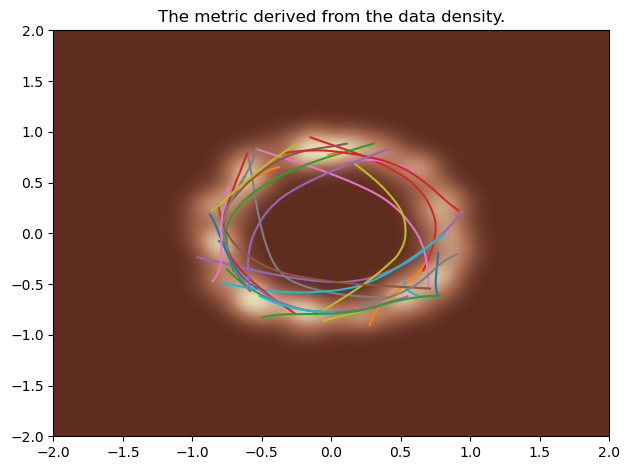

In [20]:
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
plt.contourf(x_lin, y_lin, real_bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
batch_c.plot()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("The metric derived from the data density.")
plt.tight_layout()
plt.show()

In [21]:
batch_c.euclidean_length().mean().item()

1.1809161901474

In [22]:
data_vae = embed_points_2d_to_100d(data)
train_loader = torch.utils.data.DataLoader(DumbDataset(z=data,y=data_vae), batch_size=64, shuffle=True)
data_vae.shape, data_vae.max(), data_vae.min()

((300, 100), 0.9862122, -0.99308217)

In [23]:
# normalize the data_vae and compute PCA
n_data_vae = (data_vae - data_vae.mean(axis=0)) / data_vae.std(axis=0)
data_vae_3d = PCA(n_components=3).fit_transform(n_data_vae)
# normalize the data_vae_3d
data_vae_3d = (data_vae_3d - data_vae_3d.mean(axis=0)) / data_vae_3d.std(axis=0)

In [24]:
#simple_3d_plot(data_vae_3d, num_points)
#interactive_3d_plot(data_vae_3d, num_points)

In [25]:
model = get_decoder()
model.train();

In [26]:
epochs = 40
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [27]:
# write a training loop with tqdm
model.to(device)
losses = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        opt.zero_grad()
        y_hat = model(z)
        loss = torch.nn.functional.mse_loss(y_hat, y.to(device))
        losses.append(loss.item())
        loss.backward()
        opt.step()

  0%|          | 0/40 [00:00<?, ?it/s]

In [28]:
## Put trained models in 'eval' mode
model.eval();
model.to('cpu');

In [29]:
gc.collect()

5194

In [30]:
class DecoderInducedManifold(EmbeddedManifold):
    def __init__(self, decoder):
        self.decoder = decoder
    def embed(self, c, jacobian=False):
        if jacobian:
            return self.decoder(c), vmap(jacfwd(self.decoder))(c)
            # it is strange that jacfwd is faster than jacrev
        else:
            return self.decoder(c)

In [33]:
M = DecoderInducedManifold(model)
z_grid_list = z_grid.reshape(-1, 2)
vol_by_dec = M.volume(z_grid_list).detach().numpy().reshape((grid_size, grid_size))
c, _ = M.connecting_geodesic(p0=data[curve_indices[:, 0]], p1=data[curve_indices[:, 1]])

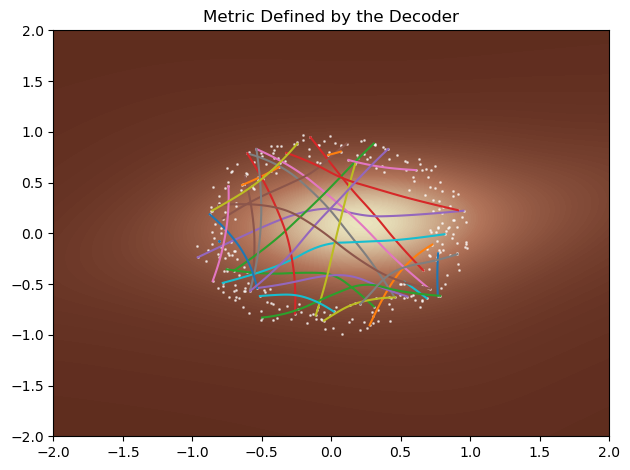

In [34]:
# Plot the magnification factor
plt.figure()
plt.contourf(x_lin, y_lin, vol_by_dec, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
c.plot()
plt.title("Metric Defined by the Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

In [35]:
# Scoring function

In [42]:
# define a score function that takes a point in 2d and returns a score which is 1 if the point is in the annulus and 0 otherwise
def score_function(points, center=(0.0,0.0), inner_radius=0.7, outer_radius=1.0):
    """
    Calculate the score for a point based on its distance from an annulus.
    Returns:
    - float: The score for the point, 1 if on the mid-circle, decreasing towards 0 outside the annulus.
    """
    cx, cy = center
    distance = torch.sqrt((points[:,0] - cx) ** 2 + (points[:,1] - cy) ** 2)
    mid_radius = (inner_radius + outer_radius) / 2
    annulus_width = outer_radius - inner_radius
    # generate mask for the annulus
    mask = (inner_radius <= distance) & (distance <= outer_radius)
    # calculate the score
    score = torch.zeros_like(distance)
    score[mask] = 1 - torch.abs(distance[mask] - mid_radius) / (annulus_width / 2)
    return score

In [44]:
scores = score_function(z_grid_list).reshape((grid_size, grid_size))
scores.shape

torch.Size([100, 100])

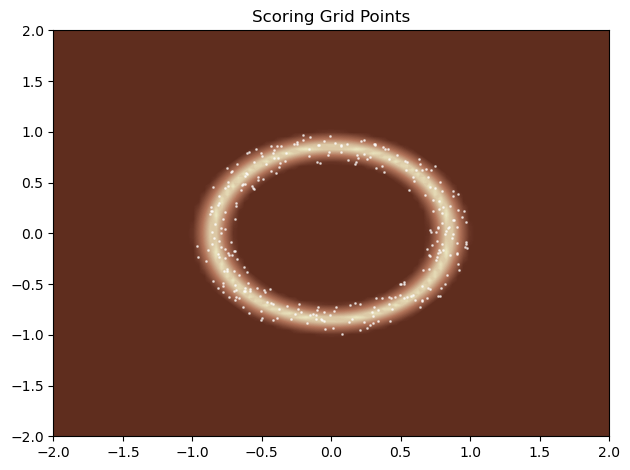

In [45]:
# Plot the magnification factor
plt.figure()
plt.contourf(x_lin, y_lin, scores, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
plt.title("Scoring Grid Points")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

In [46]:
# define a class classifier that takes a point in 2d and returns its score using pytorch
class Classifier(nn.Module):
    def __init__(self, input_dim=2):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.Tanh(),
            nn.Linear(10, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [60]:
classifier = Classifier()
classifier.train();
# define a loss function for a regression problem and an optimizer
epochs = 40
opt = torch.optim.Adam(classifier.parameters(), lr=1e-3)
loss_fn = torch.nn.L1Loss()
# define a dataloader for the training data
train_loader = torch.utils.data.DataLoader(DumbDataset(z=z_grid_list,y=scores.reshape(-1,1)), batch_size=64, shuffle=True)
# define a training loop with tqdm
classifier.to(device);

In [61]:
losses = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        y = y.to(device)
        opt.zero_grad()
        y_hat = classifier(z)
        loss = loss_fn(y_hat, y)
        losses.append(loss.item())
        loss.backward()
        opt.step()

  0%|          | 0/40 [00:00<?, ?it/s]

In [63]:
# plot the loss
#plt.plot(losses)
#plt.show()

In [54]:
classifier.eval();
with torch.no_grad():
    score_hat = classifier(z_grid_list.to(device)).detach().cpu().numpy()#.reshape((grid_size, grid_size))
score_hat.shape

(10000, 1)

In [ ]:
def nll(cls_model, z, target):
    '''
    Bayesian optimization objective.
    '''
    # Predict the score value
    c_probs = cls_model(z)

    nll_prior = -mvn.logpdf(t).reshape(-1, 1)
    nll_pred = -np.log(c_probs + 1e-8).reshape(-1, 1)

    return nll_prior + nll_pred

In [ ]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization

bounds = [{'name': 't1', 'type': 'continuous', 'domain': (-4.0, 4.0)},
          {'name': 't2', 'type': 'continuous', 'domain': (-4.0, 4.0)}]

def optimizer_for(target):

    def nll_target(t):
        return nll(t, target)

    return BayesianOptimization(f=nll_target,
                                domain=bounds,
                                model_type='GP',
                                acquisition_type ='EI',
                                acquisition_jitter = 0.01,
                                initial_design_numdata = 2,
                                exact_feval=False)

In [13]:
import os
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms import Standardize, Normalize

dtype = torch.float32 #torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST", False)

In [14]:
d = 2
bounds = torch.tensor([[-bound] * d, [bound] * d], device=device, dtype=dtype)

In [ ]:
class BayesianDecoder(nn.Module):
    def __init__(self, z_dim=2, out_dim=100, mean_value=0.0, std_value=1.0, device='cpu'):
        super(BayesianDecoder, self).__init__()
        self.z_dim = z_dim
        self.out_dim = out_dim
        self.nn = get_decoder()

    def forward(self, x, randomness=False, return_sigma=False):
        __sigma = self.sigma(x) * self.noise.sample((x.shape[0],)).to(x.device) if randomness else self.sigma(x)
        __y_hat = self.mu(x) + __sigma
        if return_sigma:
            return __y_hat, __sigma
        else:
            return __y_hat